# The Distribution of Wealth and the MPC


This notebook presents a selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit.  It sketches the steps that would need to be taken to solve the model using the [dolARK](https://github.com/EconForge/dolARK) modeling system.

In [1]:
# This cell does some standard python setup

# Tools for navigating the filesystem
import sys
import os

# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)
from copy import copy, deepcopy

# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show

# iPython gives us some interactive and graphical tools
from IPython import get_ipython # In case it was run from python instead of ipython

# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set up some special requirements for this notebook; please be patient, it may take 3-5 minutes

# Determine the platform so we can do things specific to each 
import platform
pform = ''
pform = platform.platform().lower()
if 'darwin' in pform:
    pf = 'darwin' # MacOS
if 'debian' in pform:
    pf = 'debian' # Probably cloud (MyBinder, CoLab, ...)
if 'ubuntu' in pform:
    pf = 'debian' # Probably cloud (MyBinder, CoLab, ...)
if 'win' in pform:
    pf = 'win'

# Test whether latex is installed (some of the figures require it)
from distutils.spawn import find_executable

latexExists=False

if find_executable('latex'):
    latexExists=True

if not latexExists:
    print('Some of the figures below require a full installation of LaTeX')
    
    # If running on Mac or Win, user can be assumed to be able to install
    # any missing packages in response to error messages; but not on cloud
    # so load LaTeX by hand (painfully slowly)
    if 'debian' in pf: # CoLab and MyBinder are both ubuntu
        print('Installing LaTeX now; please wait 3-5 minutes')
        from IPython.utils import io
        
        with io.capture_output() as captured: # Hide hideously long output 
            os.system('apt-get update')
            os.system('apt-get install texlive texlive-latex-extra texlive-xetex dvipng')
            latexExists=True
    else:
        print('Please install a full distributon of LaTeX on your computer then rerun.')
        print('A full distribution means textlive, texlive-latex-extras, texlive-xetex, dvipng, and ghostscript')
        sys.exit()

# If the ipython process contains 'terminal' assume not in a notebook
def in_ipynb():
    try:
        if 'terminal' in str(type(get_ipython())):
            return False
        else:
            return True
    except NameError:
        return False

# In order to use LaTeX to manage all text layout in our figures, 
# we import rc settings from matplotlib.
from matplotlib import rc

plt.rc('font', family='serif')
plt.rc('text', usetex=latexExists)
if latexExists:
    latex_preamble = r'\usepackage{amsmath}\usepackage{amsfonts}\usepackage[T1]{fontenc}'
    from os import path
    latexdefs_path = os.getcwd()+'/latexdefs.tex'
    if path.isfile(latexdefs_path):
        latex_preamble = latex_preamble+r'\input{'+latexdefs_path+r'}'
    else: # the required latex_envs package needs this file to exist even if it is empty
        from pathlib import Path
        Path(latexdefs_path).touch()
    plt.rcParams['text.latex.preamble'] = latex_preamble
    
# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')

# Code to allow a master "Generator" and derived "Generated" versions
#   - allows "$nb-Problems-And-Solutions → $nb-Problems → $nb"
Generator=True # Is this notebook the master or is it generated?

# Where to put any figures that the user wants to save
my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.ipynb")) # Find pathname to this file:
Figures_dir = os.path.join(my_file_path,"Figures/") # LaTeX document assumes figures will be here
if not os.path.exists(Figures_dir):
    os.makedirs(Figures_dir)
    
# Whether to save the figures to local filesystem
saveFigs=True

# Whether to draw the figures
drawFigs=True

if not in_ipynb(): # running in batch mode
    print('You appear to be running from a terminal')
    if drawFigs:
        print('By default, figures will appear one by one')
        
# Create, and if desired, save and show the figures
def show(figure_name, target_dir="Figures"):
    # Save the figures in several formats
    # print(f"Saving figure {figure_name} in {target_dir}")
    if saveFigs:
        plt.savefig(os.path.join(target_dir, f'{figure_name}.png')) # For web/html
        plt.savefig(os.path.join(target_dir, f'{figure_name}.jpg')) # Useful to make versions 
        plt.savefig(os.path.join(target_dir, f'{figure_name}.pdf')) # For LaTeX
        plt.savefig(os.path.join(target_dir, f'{figure_name}.svg')) # For html5
    if not in_ipynb():
        if drawFigs: # Only want to draw them if you're in a GUI
            plt.ioff()   # When plotting in the terminal, do not use interactive mode
            plt.draw()  
            plt.pause(2) # Wait a couple of secs to allow the figure to be briefly visible after being drawn
    else:
        plt.show(block=True) # Change to false if you want to run uninterrupted


## Contribution

A principle problem in consumption economics is the development of a model
that fits the empirical distribution of the marginal propensity to consume (MPC) as
a function of wealth, given that the is high wealth inequality.

Prior macroeconomic models that have assumed homogeneous agents have had the results
of low wealth inequality. Krusell and Smith (1998) were the first to explain inequality in wealth through heterogeneity of agent discount factors. They modeled each intergenerational dynasty as having a discount factor that varies over time as a Markov process. They found this increase wealth inequality.

This work finds a greater fit to the empirical distribution of wealth can be attained by modeling heterogeneity in discount factors as stable across generations. The discount factor distribution is uniform, with the breadth of the distribution determined by one free paramater. Fitting this parameter with a simple estimation process results in a model which fits the empirics better than Krusell and Smith (1998).

## Notation For the Core Model

We define the following parameters. `TODO: Define exogenous values here, endogenous elsewhere? What are the principles?`

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\pRat}{p}\pRat$ | Permanent Income | $\texttt{pRat}$ |  |
| $\newcommand{\tshk}{\zeta}\tshk$ | Transitory Income | $\texttt{tshk}$ |  |
| $\newcommand{\pshk}{\psi}\pshk$ | Permanent Shock | $\texttt{pshk}$ |  |
| $\newcommand{\Wage}{W}\Wage$ | Aggregate Wage | $\texttt{Wage}$ |  |
| $\newcommand{\mRat}{m}\mRat$ | | $\texttt{mRt}$ |  |
| $\newcommand{\kRat}{k}\kRat$ | | $\texttt{kRAt}$ |  |
| $\newcommand{\rProd}{r}\rProd$ | | $\texttt{rProd}$ |  |
| $\newcommand{\Discount}{\beta}\Discount$ | Time Preference Factor | $\texttt{Discount}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |

$\newcommand{\aRat}{a}$
$\newcommand{\cFunc}{\mathrm{c}}$
$\newcommand{\cRat}{c}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\KLev}{K}$
$\newcommand{\PDies}{\mathsf{P}}$
$\newcommand{\PLives}{\Lambda}$
$\newcommand{\uFunc}{{\mathrm{u}}}$
$\newcommand{\valfn}{\mathrm{v}}$
$\newcommand{\wEndRat}{\aRat}$
$\newcommand{\YLev}{Y}$
$\newcommand{\yLev}{y}$


Idiosyncratic (household) income process is logarithmic Friedman:
\begin{eqnarray*}
\yLev_{t+1}&=&\pRat_{t+1}\tshk_{t+1}\Wage\\
\pRat_{t+1}&=&\pRat_{t}\pshk_{t+1}
\end{eqnarray*}

$c_{t} = \cFunc_{t}(\mRat_t)$

\begin{eqnarray}
\valfn(\mRat_{t})&=&\underset{\cFunc_{t}}{\max } ~~ \uFunc(\cFunc_{t}(\mRat_t))+\Discount \PLives \Ex_{t}\left[ \pshk
_{t+1}^{1-\CRRA}\valfn(\mRat_{t+1})
\right]   \\
\notag &\text{s.t.}&\\
\wEndRat_{t} &=&\mRat_{t}-\cRat_{t},\\
\kRat_{t+1} &=&\wEndRat_{t}/(\PLives \pshk_{t+1}),
\\
\mRat_{t+1} &=&(\daleth +\rProd_t)\kRat_{t+1}+\tshk_{t+1},\\
\wEndRat_{t} &\geq &0, \label{indconst5}  %\\ \notag \rProd &=&\kapShare\ptyLev(\KLev/\labor\LLev)^{\kapShare-1},
\end{eqnarray}

# Add r

`TODO: From Bufferstock. Needs editing`
    
For a microeconomic consumer with 'Market Resources' $M_{t}$ (net worth plus current income; basically, everything the consumer owns), end-of-period assets $A_{t}$ will be the amount remaining after consuming $C_{t}$:  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t}   &=&M_{t}-C_{t}.  \label{eq:DBCparts}
\end{eqnarray}

The consumer's permanent noncapital income $P$ (in the sense of [Friedman (1957)](http://www.econ2.jhu.edu/people/ccarroll/ATheoryv3NBER.pdf)) grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable lognormally distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \PermGroFac \psi_{t+1}
\end{eqnarray}
and actual income is permanent income multiplied by a logormal multiplicative transitory shock, $\mathbb{E}_{t}[\theta_{t+1}]=1$, so that next period's market resources are
\begin{eqnarray}
%M_{t+1} &=& B_{t+1} +P_{t+1}\theta_{t+1},  \notag
M_{t+1} &=& A_{t}R +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a standard Constant Relative Risk Aversion utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{eqnarray*}

and the [Euler equation](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Consumption/Envelope) for this model is 

\begin{align*}
c_{t}^{-\rho} & = R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1})^{-\rho})] %\\
% 0 & = & R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1}/c_{t})^{-\rho})]-1
\end{align*}


## Time Preference Heterogeneneity

Our specific approach is to replace the assumption that all households have the same time
preference factor with an assumption that, for some dispersion $\nabla$, time
preference factors are distributed uniformly in the population between
$\grave{\Discount}-\nabla$ and $\grave{\Discount}+\nabla$ (for this reason, the model is referred to as the $\Discount$-Dist model).  Then,
using simulations, we search for the values of $\grave{\Discount}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. Specifically, defining $w_{i}$ and $\omega _{i}$ as the proportion of total aggregate net worth held by the top $i$ percent in our model and in the data, respectively, we solve the following minimization problem:

$$  \{\grave{\Discount}, \nabla\}= \underset{\{{\Discount}, \nabla\}}{\text{argmin} }\Big(\sum_\text{i=20, 40, 60, 80}
  \big(w_{i}({\Discount}, \nabla)-\omega _{i}\big)^{2}\Big)^{1/2}$$
  subject to the constraint that the aggregate wealth (net worth)-to-output ratio in the model matches the aggregate
capital-to-output ratio from the perfect foresight model ($\KLev_{PF}/\YLev_{PF}$). When solving the problem for the FBS specification we shut down the aggregate shocks (practically, this does not affect the estimates given their small size).
 
$$\KLev / \YLev = \KLev_{PF} / \YLev_{PF}$$

The solution to this problem is $\{\grave{\Discount}, \nabla\}=\{0.9867, 0.0067\}$
, so that the discount factors are evenly spread roughly between 0.98 and 0.99. We call the optimal value of the objective function the 'Lorenz distance' and use it as a measure of fit of the models.

The introduction of even such a relatively modest amount of time
preference heterogeneity sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data.

In [3]:
'''
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
'''
import os

'''
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
'''

here = os.path.dirname(os.path.realpath("cstwMPC.ipynb"))
my_path = os.path.join(here,'')
path_to_models = os.path.join(my_path,'Code')

In [4]:
# For speed here, use the "tractable" version of the model
'''
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
'''
param_name = 'DiscFac'        # Which parameter to introduce heterogeneity in
dist_type = 'uniform'         # Which type of distribution to use

'''
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
'''
run_estimation = True         # Runs the estimation if True
run_sensitivity = [False, False, False, False, False, False, False, False] # Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
find_beta_vs_KY = False       # Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
do_tractable = True          # Uses a "tractable consumer" rather than solving full model when True

Beginning an estimation with the specification name PYbetaPointIndNetWorth...





getKYratioDifference tried center = 0.95 and got -9.737467406398238
The given type violates the Absolute Impatience Condition with the supplied parameter values; the AIF is 1.00495  
The given parameter values violate the Growth Impatience Condition for this consumer type; the GIF is: 1.0050 


The given parameter values violate the Growth Impatience Condition for this consumer type; the GIF is: 1.0050 
getKYratioDifference tried center = 0.995 and got 65.56174461486972





getKYratioDifference tried center = 0.9558192645251606 and got -9.682962081909512





getKYratioDifference tried center = 0.9754096322625803 and got -9.30238283304393





getKYratioDifference tried center = 0.9852048161312901 and got -8.202435342294791
The given type violates the Absolute Impatience Condition with the supplied parameter values; the AIF is 1.00000  
The given parameter values violate the Growth Impatience Condition 

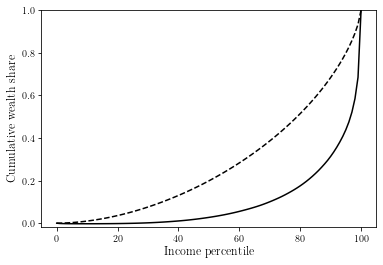

Estimate is center=0.9891395234236353, spread=0.0
Lorenz distance is 42.691225404510476
Average MPC for all consumers is 0.099
Average MPC in the top percentile of W/Y is 0.068
Average MPC in the top decile of W/Y is 0.071
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.074
Average MPC in the middle quintile of W/Y is 0.074
Average MPC in the fourth quintile of W/Y is 0.076
Average MPC in the bottom quintile of W/Y is 0.199
Average MPC in the top percentile of y is 0.075
Average MPC in the top decile of y is 0.078
Average MPC in the top quintile of y is 0.084
Average MPC in the second quintile of y is 0.114
Average MPC in the middle quintile of y is 0.123
Average MPC in the fourth quintile of y is 0.082
Average MPC in the bottom quintile of y is 0.093
Average MPC for the employed is 0.097
Average MPC for the unemployed is 0.131
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
61.057% are in the bottom wealt

In [5]:
# Solve for the $\beta-Point$ (do_param_dist=False) for speed
'''
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
'''
do_param_dist = False          # Do param-dist version if True, param-point if False
do_lifecycle = False          # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False         # Solve the FBS aggregate shocks version of the model
do_liquid = True             # Matches liquid assets data when True, net worth data when False


os.chdir(path_to_models)
exec(open('cstwMPC_MAIN.py').read())

In [ ]:
'''
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
'''
do_param_dist = True          # Do param-dist version if True, param-point if False
do_lifecycle = False          # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False         # Solve the FBS aggregate shocks version of the model
do_liquid = False             # Matches liquid assets data when True, net worth data when False

os.chdir(path_to_models)
exec(open('cstwMPC_MAIN.py').read())

Beginning an estimation with the specification name PYbetaDistIndNetWorth...
getKYratioDifference tried center = 0.95 and got -9.73574471397209
getKYratioDifference tried center = 0.995 and got 108.10737279427268
getKYratioDifference tried center = 0.9537177267658257 and got -9.701892400680814
getKYratioDifference tried center = 0.9743588633829128 and got -9.318167745132815
getKYratioDifference tried center = 0.9846794316914564 and got -6.177290169150552
getKYratioDifference tried center = 0.9898397158457282 and got 14.451949165200366
getKYratioDifference tried center = 0.9862246448745294 and got -3.033018049642135
getKYratioDifference tried center = 0.9874566283357246 and got 0.9310485365679941
getKYratioDifference tried center = 0.987167269826306 and got -0.14252313644736248
getKYratioDifference tried center = 0.9872056839195209 and got -0.005530837946649214
getKYratioDifference tried center = 0.9872072256664769 and got 2.3644569774106117e-05
getKYratioDifference tried center = 0.987